In [1]:
import geopandas as gpd
import pandas as pd

# Load the shapefiles
peru_2002 = gpd.read_file("/Users/alexander/Documents/boyco-benites/shp/2002/distritos.shp")
peru_2005 = gpd.read_file("/Users/alexander/Documents/boyco-benites/shp/2005/Distritos.shp")

# Reproject to UTM 18S (good for Peru)
peru_2002 = peru_2002.to_crs(epsg=32718)
peru_2005 = peru_2005.to_crs(epsg=32718)

# Create UBIGEO fields
peru_2002['UBIGEO_2002'] = peru_2002['CODIGO_DIS']
peru_2005['UBIGEO_2005'] = peru_2005['Codigo_dis']

# 1. Get list of UBIGEO codes
ubigeo_2002 = set(peru_2002['UBIGEO_2002'])
ubigeo_2005 = set(peru_2005['UBIGEO_2005'])

# 2. Find new UBIGEOs in 2005
new_ubigeos_in_2005 = ubigeo_2005 - ubigeo_2002

# 3. Display new districts
new_districts = peru_2005[peru_2005['UBIGEO_2005'].isin(new_ubigeos_in_2005)]

print(new_districts[['UBIGEO_2005', 'NOMBDIST']])


     UBIGEO_2005                   NOMBDIST
198       160114    TENIENTE MANUEL CLAVERO
370       211210  SAN PEDRO DE PUTINA PUNCO
407       160702                 CAHUAPANAS
835       160701                   BARRANCA
836       160705                    PASTAZA
837       160706                     ANDOAS
1827      160704                     MORONA
1828      160703                 MANSERICHE


In [2]:
# Spatial join: find which 2002 district each new 2005 district overlaps
joined = gpd.sjoin(new_districts, peru_2002, how="left", predicate="intersects")

# Show results
print(joined[['UBIGEO_2005', 'NOMBDIST', 'UBIGEO_2002', 'NOMB_DIST']])


     UBIGEO_2005                   NOMBDIST UBIGEO_2002         NOMB_DIST
198       160114    TENIENTE MANUEL CLAVERO      160109          PUTUMAYO
198       160114    TENIENTE MANUEL CLAVERO      160110    TORRES CAUSANA
370       211210  SAN PEDRO DE PUTINA PUNCO      211209     ALTO INAMBARI
370       211210  SAN PEDRO DE PUTINA PUNCO      211203           LIMBANI
370       211210  SAN PEDRO DE PUTINA PUNCO      211207  SAN JUAN DEL ORO
370       211210  SAN PEDRO DE PUTINA PUNCO      170101         TAMBOPATA
407       160702                 CAHUAPANAS      160205           JEBEROS
407       160702                 CAHUAPANAS      220101         MOYOBAMBA
407       160702                 CAHUAPANAS      160202       BALSAPUERTO
407       160702                 CAHUAPANAS      160204        CAHUAPANAS
407       160702                 CAHUAPANAS      160203          BARRANCA
835       160701                   BARRANCA      160205           JEBEROS
835       160701                   BAR

In [3]:
# Already have 'joined' table with overlaps

# Calculate overlap area (if not done)
joined['overlap_area'] = joined.geometry.area

# Keep only the biggest overlap per new district
joined_best = joined.sort_values('overlap_area', ascending=False).drop_duplicates('UBIGEO_2005')

# Show clean result
print(joined_best[['UBIGEO_2005', 'NOMBDIST', 'UBIGEO_2002', 'NOMB_DIST']])


     UBIGEO_2005                   NOMBDIST UBIGEO_2002     NOMB_DIST
837       160706                     ANDOAS      160304   TROMPETEROS
1827      160704                     MORONA      010403  RIO SANTIAGO
198       160114    TENIENTE MANUEL CLAVERO      160109      PUTUMAYO
836       160705                    PASTAZA      160206       LAGUNAS
835       160701                   BARRANCA      010312  YAMBRASBAMBA
370       211210  SAN PEDRO DE PUTINA PUNCO      170101     TAMBOPATA
407       160702                 CAHUAPANAS      220101     MOYOBAMBA
1828      160703                 MANSERICHE      160207    MANSERICHE


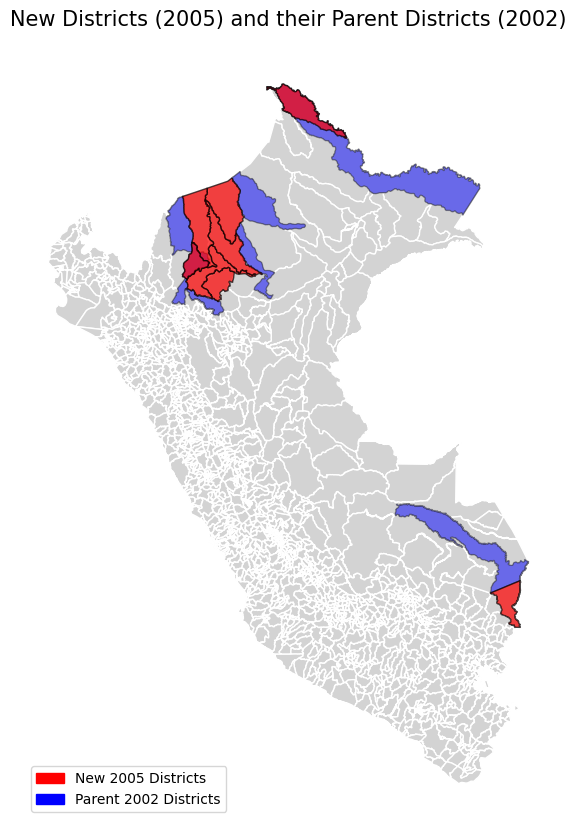

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# List of new 2005 UBIGEOs
new_ubigeos = [
    '160706', '160704', '160114', '160705', '160701', '211210', '160702', '160703'
]

# List of parent 2002 UBIGEOs
parent_ubigeos = [
    '160304', '010403', '160109', '160206', '010312', '170101', '220101', '160207'
]

# Subset shapefiles
new_districts = peru_2005[peru_2005['UBIGEO_2005'].isin(new_ubigeos)]
parent_districts = peru_2002[peru_2002['UBIGEO_2002'].isin(parent_ubigeos)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all Peru 2002 districts in light grey
peru_2002.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot parent districts (2002) in blue
parent_districts.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# Plot new districts (2005) in red
new_districts.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

# Titles and legend
ax.set_title('New Districts (2005) and their Parent Districts (2002)', fontsize=15)
ax.axis('off')

# Optional: Add a manual legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='New 2005 Districts')
blue_patch = mpatches.Patch(color='blue', label='Parent 2002 Districts')
plt.legend(handles=[red_patch, blue_patch], loc='lower left')

plt.savefig('map2002_2005.png',dpi=600)

plt.show()
